In [2]:
# Copyright (c) OpenMMLab. All rights reserved.
import collections
import copy
from typing import List, Sequence, Union

from mmengine.dataset import BaseDataset
from mmengine.dataset import ConcatDataset as MMENGINE_ConcatDataset
from mmengine.dataset import force_full_init

from mmdet.registry import DATASETS, TRANSFORMS

class MultiImageMixDataset:
    """A wrapper of multiple images mixed dataset.

    Suitable for training on multiple images mixed data augmentation like
    mosaic and mixup. For the augmentation pipeline of mixed image data,
    the `get_indexes` method needs to be provided to obtain the image
    indexes, and you can set `skip_flags` to change the pipeline running
    process. At the same time, we provide the `dynamic_scale` parameter
    to dynamically change the output image size.

    Args:
        dataset (:obj:`CustomDataset`): The dataset to be mixed.
        pipeline (Sequence[dict]): Sequence of transform object or
            config dict to be composed.
        dynamic_scale (tuple[int], optional): The image scale can be changed
            dynamically. Default to None. It is deprecated.
        skip_type_keys (list[str], optional): Sequence of type string to
            be skip pipeline. Default to None.
        max_refetch (int): The maximum number of retry iterations for getting
            valid results from the pipeline. If the number of iterations is
            greater than `max_refetch`, but results is still None, then the
            iteration is terminated and raise the error. Default: 15.
    """

    def __init__(self,
                 dataset: Union[BaseDataset, dict],
                 pipeline: Sequence[str],
                 skip_type_keys: Union[Sequence[str], None] = None,
                 max_refetch: int = 15,
                 lazy_init: bool = False) -> None:
        assert isinstance(pipeline, collections.abc.Sequence)
        if skip_type_keys is not None:
            assert all([
                isinstance(skip_type_key, str)
                for skip_type_key in skip_type_keys
            ])
        self._skip_type_keys = skip_type_keys

        self.pipeline = []
        self.pipeline_types = []
        for transform in pipeline:
            if isinstance(transform, dict):
                self.pipeline_types.append(transform['type'])
                transform = TRANSFORMS.build(transform)
                self.pipeline.append(transform)
            else:
                raise TypeError('pipeline must be a dict')

        self.dataset: BaseDataset
        if isinstance(dataset, dict):
            self.dataset = DATASETS.build(dataset)
        elif isinstance(dataset, BaseDataset):
            self.dataset = dataset
        else:
            raise TypeError(
                'elements in datasets sequence should be config or '
                f'`BaseDataset` instance, but got {type(dataset)}')

        self._metainfo = self.dataset.metainfo
        if hasattr(self.dataset, 'flag'):
            self.flag = self.dataset.flag
        self.num_samples = len(self.dataset)
        self.max_refetch = max_refetch

        self._fully_initialized = False
        if not lazy_init:
            self.full_init()

    @property
    def metainfo(self) -> dict:
        """Get the meta information of the multi-image-mixed dataset.

        Returns:
            dict: The meta information of multi-image-mixed dataset.
        """
        return copy.deepcopy(self._metainfo)

    def full_init(self):
        """Loop to ``full_init`` each dataset."""
        if self._fully_initialized:
            return

        self.dataset.full_init()
        self._ori_len = len(self.dataset)
        self._fully_initialized = True

    @force_full_init
    def get_data_info(self, idx: int) -> dict:
        """Get annotation by index.

        Args:
            idx (int): Global index of ``ConcatDataset``.

        Returns:
            dict: The idx-th annotation of the datasets.
        """
        return self.dataset.get_data_info(idx)

    @force_full_init
    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        results = copy.deepcopy(self.dataset[idx])
        for (transform, transform_type) in zip(self.pipeline,
                                               self.pipeline_types):
            if self._skip_type_keys is not None and \
                    transform_type in self._skip_type_keys:
                continue

            if hasattr(transform, 'get_indexes'):
                for i in range(self.max_refetch):
                    # Make sure the results passed the loading pipeline
                    # of the original dataset is not None.
                    indexes = transform.get_indexes(self.dataset)
                    if not isinstance(indexes, collections.abc.Sequence):
                        indexes = [indexes]
                    mix_results = [
                        copy.deepcopy(self.dataset[index]) for index in indexes
                    ]
                    if None not in mix_results:
                        results['mix_results'] = mix_results
                        break
                else:
                    raise RuntimeError(
                        'The loading pipeline of the original dataset'
                        ' always return None. Please check the correctness '
                        'of the dataset and its pipeline.')

            for i in range(self.max_refetch):
                # To confirm the results passed the training pipeline
                # of the wrapper is not None.
                updated_results = transform(copy.deepcopy(results))
                if updated_results is not None:
                    results = updated_results
                    break
            else:
                raise RuntimeError(
                    'The training pipeline of the dataset wrapper'
                    ' always return None.Please check the correctness '
                    'of the dataset and its pipeline.')

            if 'mix_results' in results:
                results.pop('mix_results')

        return results


In [24]:
from mmdet.datasets.coco import CocoDataset
data_root='../dataset'
metainfo = {
    'classes': ("General trash", "Paper", "Paper pack", "Metal", "Glass", 
           "Plastic", "Styrofoam", "Plastic bag", "Battery", "Clothing"),
    'palette': [(220, 20, 60), (119, 11, 32), (0, 0, 142), (0, 0, 230), (106, 0, 228),
         (0, 60, 100), (0, 80, 100), (0, 0, 70), (0, 0, 192), (250, 170, 30)]
}

img_scale = (640, 640)

train_pipeline = [
    dict(
        type='custom_mosaic_copy_paste',paste_by_box=True),
    dict(type='FilterAnnotations', min_gt_bbox_wh=(50, 50), keep_empty=False),
]

cp_dataset = MultiImageMixDataset(
    CocoDataset(metainfo = metainfo,
        data_root=data_root,
        ann_file='train.json',
        data_prefix=dict(img= data_root),
        filter_cfg=dict(filter_empty_gt=False),
        pipeline=[
            dict(type='LoadImageFromFile'),
            dict(type='LoadAnnotationswithbox', with_bbox=True, with_labels=True)
        ]),
        pipeline=train_pipeline
)

loading annotations into memory...
Done (t=0.07s)
creating index...
index created!


In [25]:
import cv2
import matplotlib.pyplot as plt
classes = {0:"general trash",1:"Paper",2:"Paper pack",3:"Metal",4:"Glass",5:"Plastic",6:"Styrofoam",7:"Plastic bag",8:"Battery",9:"Clothing"}

def visulize(item_num):
    file_name = cp_dataset.__getitem__(item_num)
    img = file_name['img']
    if img is None:
        print(f"Unable to read image: {item_num}")
    
    labels = file_name['gt_bboxes_labels']
    boxes = file_name['gt_bboxes']

    for label,k in zip(labels,boxes.numpy()):
        label_num = int(label)  # 첫 번째 요소를 라벨로 사용
        label = classes[label_num]
        pt1 = (int(float(k[0])), int(float(k[1])))
        pt2 = (int(float(k[2])), int(float(k[3])))
        
        # 바운딩 박스 그리기
        cv2.rectangle(img, pt1, pt2, (0, 255, 0), 2)
        
        # 라벨 텍스트 준비
        label_text = f"{label}"
        
        # 라벨 배경 크기 계산
        text_size = cv2.getTextSize(label_text, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 2)[0]
        
        # 라벨 배경 그리기
        cv2.rectangle(img, 
                    (pt1[0], pt1[1] - text_size[1] - 4), 
                    (pt1[0] + text_size[0], pt1[1]), 
                    (0, 255, 0), 
                    -1)
        
        # 라벨 텍스트 그리기
        cv2.putText(img, label_text, 
                    (pt1[0], pt1[1] - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 2)
    
    plt.imshow(img)

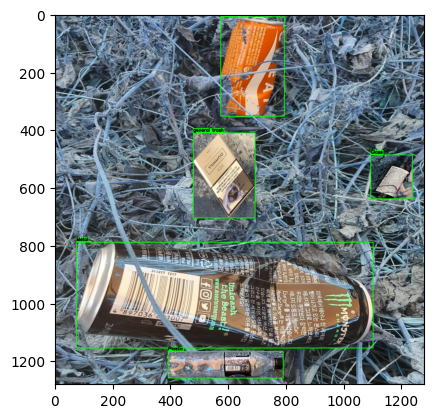

In [32]:
visulize(22)